<a href="https://colab.research.google.com/github/SeanSDarcy2001/games/blob/main/dominoRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import numpy as np
import random
from itertools import cycle, islice
from collections import deque

In [24]:
#objects

class Player() :

  def __init__(self, Name, intelligent = False) :
    self.name = Name
    self.hand = []
    self.intel = False
    self.state = np.zeros((70,1))
    self.prev_state = np.zeros((70,1))
    self.prev_action = np.zeros((56,1))
    self.turn = 0
    if intelligent :
      self.intel = True
      # Get number of actions from action space
      n_actions = 56
      # Get the number of state observations
      n_observations = 56 + 14 #dominos on board plus dominos in hand plus whats on left plus whats on right
      self.policy_net = DQN(n_observations, n_actions).to(device)
      self.target_net = DQN(n_observations, n_actions).to(device)
      self.target_net.load_state_dict(self.policy_net.state_dict())
      self.LR = 1e-2
      self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
      self.memory = ReplayMemory(10000)
      self.BATCH_SIZE = 200
      self.GAMMA = 0.99
      self.TAU = 0.005


  def optimize_model(self):
    if len(self.memory) < self.BATCH_SIZE:
        return
    transitions = self.memory.sample(self.BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          #batch.next_state)), device=device, dtype=torch.bool)

    #non_final_next_states = torch.cat([s for s in batch.next_state
                                                #if s is not None])

    non_final_next_states = torch.cat(batch.next_state[:])
    non_final_next_states = torch.reshape(non_final_next_states, [self.BATCH_SIZE, 1, 70])

    state_batch = torch.cat(batch.state[:])
    state_batch = torch.reshape(state_batch, [self.BATCH_SIZE, 1, 70])
    #print(state_batch.shape)
    action_batch = torch.cat(batch.action)
    #print(action_batch.shape)
    action_batch = torch.reshape(action_batch, [self.BATCH_SIZE, 1])
    reward_batch = torch.cat(batch.reward)

    #print(action_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = self.policy_net(state_batch.squeeze()).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values = self.target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    #print(next_state_values.shape)
    reward_batch = torch.reshape(reward_batch, [self.BATCH_SIZE, 1])
    #print(reward_batch.shape)
    expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()


  def obtainHand(self, sevenDominos) :
    for doms in sevenDominos :
      self.hand.append(doms)

  def displayHand(self) :
    print(self.name, " has ", str(len(self.hand)), " dominos left.")
    for doms in self.hand :
      print("%%%%%%")
      #doms.printDom()
      print(doms)

  def getValueOfHand(self) :
    value = 0
    for doms in self.hand :
      a, b = doms
      value = value + a + b
      #doms.printDom()
    print(self.name)
    print("hand value:")
    print(value)
    return value

  def placeDomino(self, board) :
    a, b = board.getEnds()
    self.state = board.getState()
    action_mask = np.zeros((56,56))
    if self.intel :



      for doms in self.hand: #update hand portion of state vector
        indexOfDomino = board.lookUpTable.index(doms)
        self.state[14 + 28 + indexOfDomino] = 1

        r, l = doms #will create an action mask
        if r == a or l == a :
          action_mask[indexOfDomino, indexOfDomino] = 1
        if r == b and l == b :
          action_mask[28 + indexOfDomino, 28 + indexOfDomino] = 1


      state = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)

      if self.turn >= 1 :
        prev_state = torch.tensor(self.prev_state, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        self.memory.push(prev_state, self.prev_action, state, self.prev_reward)


        self.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_net.load_state_dict(target_net_state_dict)

      with torch.no_grad():
        #print(self.policy_net(state.squeeze()).unsqueeze(0).shape)
        actions = torch.matmul(self.policy_net(state.squeeze()).unsqueeze(0), torch.tensor(action_mask, dtype=torch.float32, device=device))

        action = torch.argmax(actions)
        actionValue = torch.max(actions)

      #print(action)
      #print(actionValue)

      #assuming action of index of max neuron for now
      if action < 28 and actionValue > 0:
        dominoToPlace = board.lookUpTable[action]
        board.addDomino(dominoToPlace, "L")
        self.hand.remove(dominoToPlace)
        reward = (dominoToPlace[0] + dominoToPlace[1]) / 12
        if len(self.hand) == 0 :
          reward = 1
      elif action >= 28 and actionValue > 0  :
        dominoToPlace = board.lookUpTable[action - 28]
        board.addDomino(dominoToPlace, "R")
        self.hand.remove(dominoToPlace)
        reward = (dominoToPlace[0] + dominoToPlace[1]) / 12
        if len(self.hand) == 0 :
          reward = 1
      else :
        reward = 0

      reward = torch.tensor([reward], device=device)

      self.prev_state = self.state
      self.prev_reward = reward
      print(torch.argmax(actions))
      self.prev_action = torch.argmax(actions).unsqueeze(0)
      self.turn += 1

      #this will be sent to q-net for action inference

    else :
      for doms in self.hand :
        val1, val2 = doms
        if val1 == a :
          board.addDomino(doms, "L")
          self.hand.remove(doms)
          return 1
        elif val1 == b :
          board.addDomino(doms, "R")
          self.hand.remove(doms)
          return 1
        elif val2 == a  :
          board.addDomino(doms, "L")
          self.hand.remove(doms)
          return 1
        elif val2 == b :
          board.addDomino(doms, "R")
          self.hand.remove(doms)
          return 1
    return 0



class Board() :
  def __init__(self, firstDomino) :
    self.board = deque()
    self.left, self.right = firstDomino
    self.lookUpTable = DominoSet().box


  def addDomino(self, domino, side) :
    a, b = domino
    if side == "R" :
      if self.right == a :
        self.board.append(domino)
        self.right = b
      elif self.right == b :
        self.board.append(domino)
        self.right = a
      else :
        print("Invalid move")
    elif side == "L" :
      if self.left == a :
        self.board.appendleft(domino)
        self.left = b
      elif self.left == b :
        self.board.appendleft(domino)
        self.left = a
      else :
        print("Invalid move")

  def getEnds(self) :
    return self.left, self.right

  def getState(self) :
    #dominoL = self.board[0]
    #dominoR = self.board[-1]
    #a, c = dominoA.getVals() #care about a from a
    #d, b = dominoB.getVals() #care about b from b
    state = np.zeros((70,1)) #create state vector
    for doms in self.board:
      indexOfDomino = self.lookUpTable.index(doms)
      state[14 + indexOfDomino] = 1
    state[self.left] = 1
    state[7 + self.right] = 1
    return state

class Domino() :

  def __init__(self, a, b) :
    self.val1 = a
    self.val2 = b

  def printDom(self) :
    print(self.val1)
    print("=")
    print(self.val2)

  def getVals(self) :
    return self.val1, self.val2

class DominoSet() :
  def __init__(self) :
    self.box = []
    for i in range(7) :
      for j in range(7) :
        if j >= i :
          self.box.append((i, j))

  def printBox(self) :
    for doms in self.box :
      print("%%%%%%")
      #doms.printDom()
      print(doms)

  def giveToPlayer(self) :
    playerDoms = []
    for k in range(7) :
      random_dom = random.choice(self.box)
      self.box.remove(random_dom)
      playerDoms.append(random_dom)
    return playerDoms

class gameSimulation() :


  def __init__(self, playersInGame) :
    self.players = playersInGame
    dominos = DominoSet()
    self.gameState = np.zeros((70,1))
    self.gameAction = np.zeros((56,1))

    for player in self.players :
      fromBox = dominos.giveToPlayer() #gets 7 seven random dominos
      for doms in fromBox : #checks whos got the 6\\6
        if doms == (6, 6) :
          self.startingPlayer = player
          self.gameBoard = Board(doms)
          fromBox.remove(doms)
      player.obtainHand(fromBox) #gives dominos to player


    #reorder player list based on starting player
    print(self.startingPlayer.name)
    print("starts.")
    indexOfPlayer = self.players.index(self.startingPlayer) + 1
    if indexOfPlayer == len(self.players) :
      indexOfPlayer = 0
    self.players = self.reorder_players(indexOfPlayer)

  def reorder_players(self, index):
    if index >= len(self.players):
        return self.players  # Index out of range, return the original list
    # Split the list into two parts
    first_part = self.players[:index]
    second_part = self.players[index:]
    # Concatenate the second part with the first part
    reordered_lst = second_part + first_part
    return reordered_lst


  def runGame(self) :
    running = True
    played = [1, 1, 1, 1]
    counter = 0
    for player in cycle(self.players) :


      if running == False : #terminal condition for once game ends
        break
      print("=============")

      player.displayHand()
      played[counter] = player.placeDomino(self.gameBoard) #will return 0 if player passes


      print(played[counter])
      counter += 1
      if counter == len(self.players) :
        counter = 0

      if len(player.hand) == 0 :
        print(player.name)
        print("wins.")
        running = False
        handValues = [0, 0, 0, 0]
        for i, remaining in enumerate(self.players) :
          handValues[i] = remaining.getValueOfHand()
        points = np.sum(handValues)
        print(points)
        print("points earned.")
        if player.name == "Seby" :
          print("=============")
          return 1
        else :
          print("=============")
          return 0

      if played == [0, 0, 0, 0] :
        print("se cerro.")
        running = False
        handValues = [0, 0, 0, 0]
        for i, remaining in enumerate(self.players) :
          handValues[i] = remaining.getValueOfHand()
        winner = np.argmin(handValues)
        print(self.players[winner].name)
        print("wins.")
        if self.players[winner].name == "Seby" :
          print("=============")
          return 1
        else :
          print("=============")
          return 0






  def resetGame(self) :
    for plyr in self.players :
      plyr.hand = []






In [ ]:
players = [Player("Seby"), Player("Mino"), Player("Tita"), Player("Gordo")]
sim = gameSimulation(players)
sim.runGame()

Streaming output truncated to the last 5000 lines.
tensor(0)
0
Mino  has  3  dominos left.
%%%%%%
(4, 4)
%%%%%%
(3, 4)
%%%%%%
(0, 2)
0
Tita  has  2  dominos left.
%%%%%%
(4, 5)
%%%%%%
(1, 5)
1
Gordo  has  2  dominos left.
%%%%%%
(0, 5)
%%%%%%
(0, 4)
1
Seby  has  3  dominos left.
%%%%%%
(1, 4)
%%%%%%
(0, 3)
%%%%%%
(2, 6)
tensor(0)
0
Mino  has  3  dominos left.
%%%%%%
(4, 4)
%%%%%%
(3, 4)
%%%%%%
(0, 2)
1
Tita  has  1  dominos left.
%%%%%%
(1, 5)
0
Gordo  has  1  dominos left.
%%%%%%
(0, 5)
0
Seby  has  3  dominos left.
%%%%%%
(1, 4)
%%%%%%
(0, 3)
%%%%%%
(2, 6)
tensor(0)
0
Mino  has  2  dominos left.
%%%%%%
(4, 4)
%%%%%%
(3, 4)
0
se cerro.
Seby
hand value:
16
Mino
hand value:
15
Tita
hand value:
6
Gordo
hand value:
5
Gordo
wins.
Mino
starts.
Tita  has  7  dominos left.
%%%%%%
(5, 5)
%%%%%%
(2, 6)
%%%%%%
(2, 2)
%%%%%%
(0, 1)
%%%%%%
(2, 3)
%%%%%%
(0, 6)
%%%%%%
(0, 2)
1
Gordo  has  7  dominos left.
%%%%%%
(4, 4)
%%%%%%
(2, 5)
%%%%%%
(1, 6)
%%%%%%
(3, 4)
%%%%%%
(1, 2)
%%%%%%
(5, 6)
%%%%%%
(4,

Text(0.5, 1.0, 'Performace')

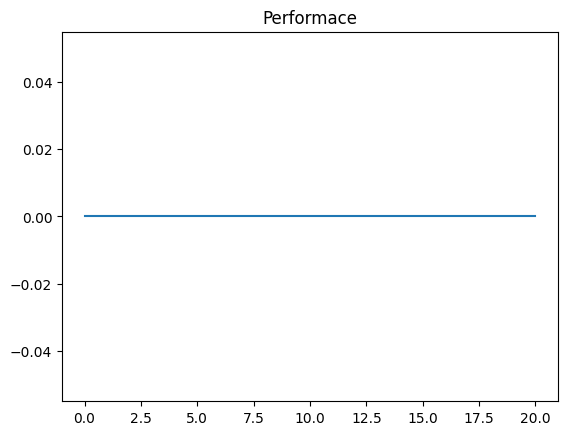

In [25]:
players = [Player("Seby", intelligent=True), Player("Mino"), Player("Tita"), Player("Gordo")]

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 20

performance = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    sim = gameSimulation(players)
    performance.append(sim.runGame())
    sim.resetGame()

plt.figure()
plt.plot(np.linspace(0, num_episodes, num_episodes), performance)
plt.title("Performace")


intelligence

In [4]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

In [56]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 5
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from action space
n_actions = 56
# Get the number of state observations
n_observations = 56 + 14 #dominos on board plus dominos in hand plus whats on left plus whats on right

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long) ##game_sim


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [57]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [58]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state

    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

NameError: ignored